In [1]:
import cdsapi
import os
import glob
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from mpl_toolkits.basemap import Basemap


In [2]:
import sys
sys.path.append('../dataproc/')
from utils import *

In [3]:
ERA5_VARIABLES = ["geopotential"]

In [4]:
def is_stub_already_present(dest_folder, stub):
  stubs = [x.split('/')[-1] for x in glob.glob(dest_folder+"*.nc")]
  if stub in stubs: 
      print(f"Present: {stub}")
      return True
  return False

def get_nbox_from_wbox(wbox):
    west_lon, south_lat, east_lon, north_lat = wbox
    nbox = [north_lat, west_lon, south_lat, east_lon]
    return nbox

def fetch_era5_data(date, nbox, filepath):
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': ERA5_VARIABLES,
            'year': f'{date.year}',
            'month': f'{date.month:02}',
            'day': [f'{date.day:02}'],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': nbox,
        },
        filepath)

def download_era5(date, name, nbox, abbv):
    dest_folder = f'{BASE_DIR}/'
    os.makedirs(dest_folder, exist_ok=True)
    
    stub = f'ERA5_{abbv.upper()}_{date.year}{date.month:02}{date.day:02}.nc'
    filepath = f'{dest_folder}{stub}'

    print(f'[{name}] - {date.strftime("%Y-%m-%d")} - Downloading file ... ')
    if not is_stub_already_present(dest_folder, stub):
        fetch_era5_data(date, nbox, filepath)
    print(f'[{name}] - {date.strftime("%Y-%m-%d")} - Downloaded.')

In [5]:
BASE_DIR = "./test"
WGEO_WBOX = (-180, -90, 0, 90)
date = datetime.utcnow() - timedelta(days=10)
download_era5(date, "test", get_nbox_from_wbox(WGEO_WBOX), "test")

[test] - 2023-06-12 - Downloading file ... 
Present: ERA5_TEST_20230612.nc
[test] - 2023-06-12 - Downloaded.


In [6]:
map_x0, map_y0 = -100.1918, 2.0617 ; hs_length = 32
map_bounds = get_bbox_square(map_x0, map_y0, hs_length)
era5_nc_files = sorted(glob.glob(f'{BASE_DIR}/*.nc'))
mc_era5, era5_map_bounds =  get_era5_map(era5_nc_files, map_bounds)

/vol/bitbucket/pn222/venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [7]:
def get_map_img(m, ax, data, map_bounds,
                x=None, y=None, contour=False,
                title=None,
                y_labels=[1, 0, 0, 0],
                x_labels=[0, 0, 0, 1], colorbar=False):
    
    kwargs = {
        "linewidth": 0.5,
        "color": "k",
        "ax": ax
    }

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        
    m.drawcoastlines(**kwargs)
    m.drawcountries(**kwargs)
    m.drawstates(**kwargs)

    if contour: im = m.contourf(x, y, data, cmap='jet', ax=ax)
    else: im = m.imshow(data, origin='upper', extent=map_bounds, cmap="gray", ax=ax)

    m.drawparallels(range(int(map_bounds[1])-1, int(map_bounds[3]), 7), labels=y_labels, fontsize=10, ax=ax)
    m.drawmeridians(range(int(map_bounds[0])-1, int(map_bounds[2]), 7), labels=x_labels, fontsize=10, ax=ax)

    if title: ax.set_title(title)

    if colorbar:
        fig.colorbar(im, cax=cax, orientation='vertical')    

    return im

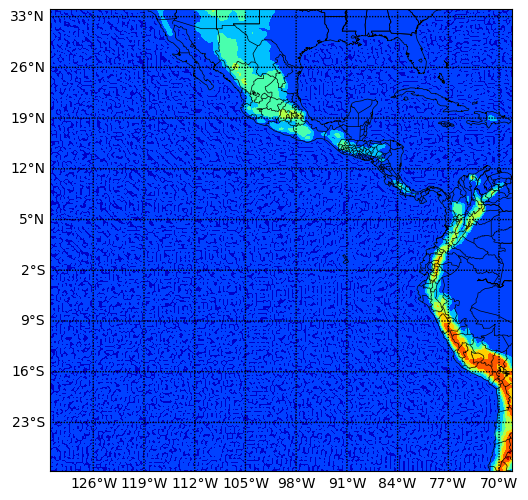

In [8]:
m = Basemap(llcrnrlon=era5_map_bounds[0], llcrnrlat=era5_map_bounds[1],
            urcrnrlon=era5_map_bounds[2], urcrnrlat=era5_map_bounds[3],
            projection='cyl', resolution='l')

lat = mc_era5.variables["latitude"][:]
lon = mc_era5.variables["longitude"][:]
lon_grid, lat_grid = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()

data = mc_era5.variables['z'][:][6]

get_map_img(m, ax, data, era5_map_bounds,
                         lon_grid, lat_grid, 
                         y_labels=[1, 0, 0, 0],
                         x_labels=[0, 0, 0, 1],
                         contour=True)       